In [2]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing
import math
from tqdm import tqdm

## Testing out random points along vertices

[<LINESTRING (-41429.334 6704202.47, -47900.741 6678221.2)>, <LINESTRING (-47900.741 6678221.2, 23161.849 6706903.35)>, <LINESTRING (-41429.334 6704202.47, 23161.849 6706903.35)>]


<Axes: >

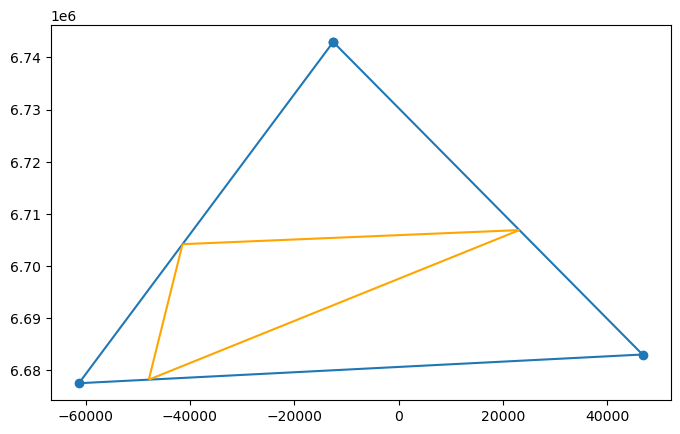

In [3]:
gdf = gpd.read_file('geojson_polygons/triangle.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

gdf_bounds = gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in gdf.boundary[0].coords], columns=['geometry']),geometry='geometry')

gdf_verts = shapely.LineString([shapely.Point(x) for x in gdf.boundary[0].coords][0:2])


def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

gdf_verts = gpd.GeoDataFrame(pd.DataFrame(segments(gdf.boundary[0]), columns=['geometry']), geometry='geometry')

def point_on_line(line):
    p1 = line.coords[0]
    p2 = line.coords[-1]
    u = random.uniform(0,1)
    
    x1 = [(1-u) * x for x in p1]
    x2 = [u*x for x in p2]
    return Point(np.add(x1,x2))

def points_on_vertices(shape):
    vertices = segments(shape.boundary[0])
    return gpd.GeoDataFrame(pd.DataFrame([point_on_line(x) for x in vertices], columns=['geometry']),geometry='geometry')

def inner_polygon(shape):
    vertices = segments(shape.boundary[0])
    points_list = [point_on_line(x) for x in vertices]
    linestring_list = [LineString([points_list[i], points_list[i+1]]) for i in range(len(points_list)-1)] + [LineString([points_list[0], points_list[-1]])]
    return points_list, linestring_list

def inner_polygons(shape, n=1):
    poly_list = []
    for i in range(n):
        _, poly =  inner_polygon(shape)
        poly_list += poly
    print(poly_list)
    return gpd.GeoDataFrame(pd.DataFrame(poly_list, columns=['geometry']), geometry='geometry')

inner_polys = inner_polygons(gdf)

fig, ax = plt.subplots(1,1,figsize=(8,8))

gdf_bounds.plot(ax=ax)
gdf_verts.iloc[:,:].plot(ax=ax)
inner_polys.plot(ax=ax, color='orange')


## Testing out polygon/vertex buffers

            Name                                           geometry
0     NORTH WEST  POLYGON Z ((712628.801 740370.193 0.000, 71262...
1  NORTH CENTRAL  POLYGON Z ((723376.597 738898.086 0.000, 72337...
2     SOUTH EAST  POLYGON Z ((714674.273 732453.119 0.000, 71464...
3  SOUTH CENTRAL  POLYGON Z ((715059.495 734107.257 0.000, 71505...
4        CENTRAL  POLYGON Z ((713734.291 734380.708 0.000, 71373...


<Axes: >

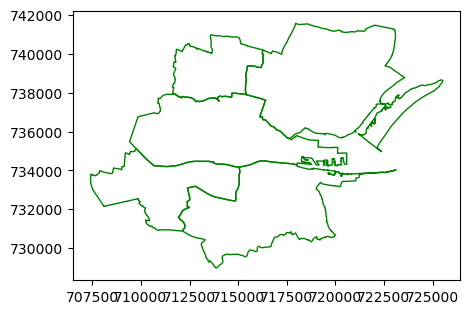

In [4]:
gdf = gpd.read_file('geojson_polygons/dcc.geojson')
convert = False
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

print(gdf)

#gdf_buffer = gdf.buffer(-100000)

fig, ax = plt.subplots(1,1,figsize=(5,5))

#gdf_buffer.plot(ax=ax, facecolor='orange')
gdf.plot(ax=ax, facecolor='none', edgecolor='green', label='name')

## Taking a look at plotting ways from OSM

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

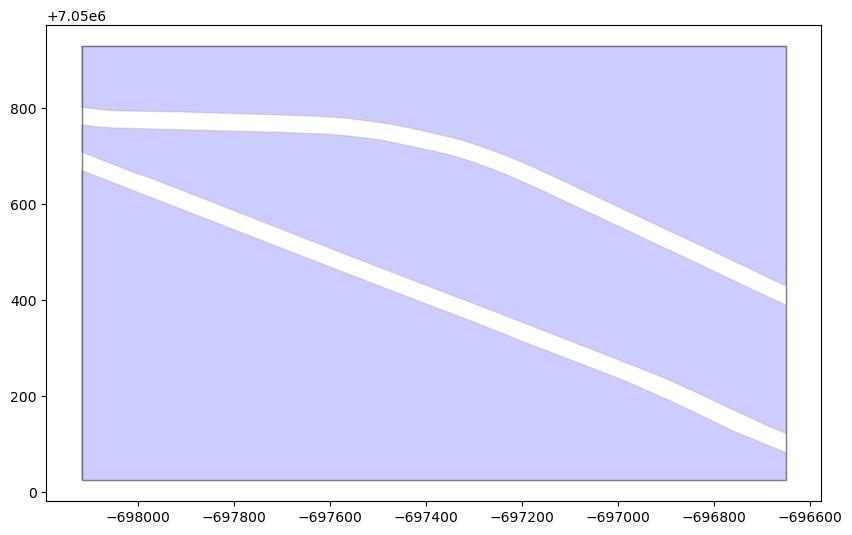

In [5]:
dcc = gpd.read_file('geojson_polygons/whitworth.geojson').to_crs(3857)
rail = gpd.read_file('geojson_polygons/whitworth_rail.geojson').to_crs(3857)

rail = rail[rail['geometry'].geom_type == "LineString"]

rail_buffer = gpd.GeoDataFrame(pd.DataFrame(rail.buffer(15), columns=['geometry']), geometry='geometry')

join_test = dcc.overlay(rail_buffer, how='symmetric_difference')
join_test2 = dcc.overlay(join_test, how='intersection')

fig, ax = plt.subplots(1,1,figsize=(10,10))
#dcc.plot(ax=ax, facecolor='none', edgecolor='green')
#rail_buffer.plot(ax=ax, color='orange')
dcc.plot(ax=ax,facecolor='none', edgecolor='grey')


##join_test.plot(ax=ax, facecolor='pink', edgecolor='grey')
join_test2.plot(ax=ax, facecolor='blue', edgecolor='grey', alpha=0.2)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


## Trying out tiling shapes over given Polygons

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


<Axes: >

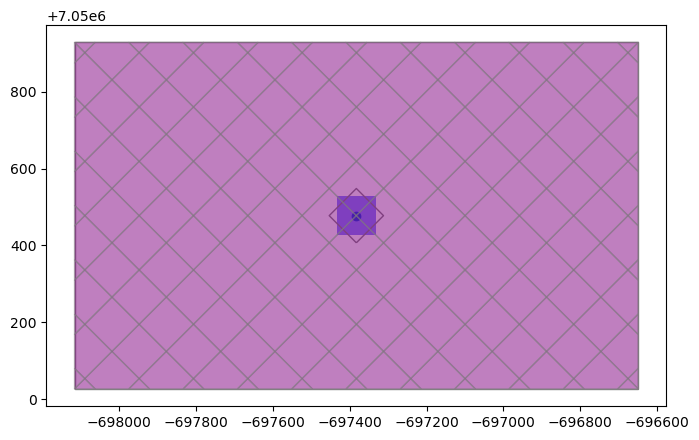

In [10]:
#square = Polygon([(-0.5, -0.5), (-0.5, 0.5), (0.5, 0.5), (0.5,-0.5)])
square = Polygon([(0.5,0.5),(0.5,1),(1,1),(1,0.5)])
pi = np.pi

def square_rotation(square, angle):
    R = np.matrix([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    origin = np.matrix([square.centroid.x, square.centroid.y]) 
    return Polygon(((np.matrix(square.exterior.coords[:-1]) - origin) * R) + origin)

def square_origin(origin, side):
    #z = np.sqrt(area)/2
    z = side/2
    ox, oy = origin.x, origin.y
    return Polygon([(ox-z,oy-z),(ox-z,oy+z), (ox+z, oy+z), (ox+z, oy-z)])

def get_bb(shape):
    bb = get_shape_bounds(shape)
    bb_poly = Polygon([(bb[0],bb[1]),(bb[0], bb[-1]),(bb[-2], bb[-1]),(bb[-2], bb[1])])
    return gpd.GeoDataFrame(pd.DataFrame([bb_poly], columns=['geometry']), geometry='geometry')

def get_bounds_points(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.boundary.coords], columns=['geometry']),geometry='geometry')

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def tile_squares(shape, side, angle):
    ox, oy = shape.centroid.x, shape.centroid.y
    minx, miny, maxx, maxy = get_shape_bounds(shape.rotate(angle, origin=Point([ox,oy])))
    w = maxx - minx
    h = maxy - miny

    ratio = w/h

    # if ratio > 1: wider than tall
    # if ratio <1 : taller than wide
    x_ratio = y_ratio = (ratio + 2)

    if ratio > 1:
        x_ratio /= 2
    else:
        y_ratio /= 2

    grid_x = int(x_ratio * np.ceil(w/side)) + 1
    grid_y = int(y_ratio * np.ceil(h/side)) + 1

    w_offset = abs(w - (side * grid_x))
    h_offset = abs(h - (side * grid_y))

    x = ox - (w/2 + w_offset/2) + side/2
    y = oy - (h/2 + h_offset/2) + side/2

    square_list = []
    for i in range(grid_x):
        for j in range(grid_y):
            origin = Point([x + (i*side), y + (j*side)])
            square_list.append(square_origin(origin, side))

    squares = gpd.GeoDataFrame(pd.DataFrame(square_list, columns=['geometry']), geometry='geometry')
    squares_rotate = gpd.GeoDataFrame(geometry=squares.rotate(angle, origin=Point([ox,oy])), crs=shape.crs) 
    return shape.overlay(squares_rotate, how='intersection',keep_geom_type=False)

gdf = gpd.read_file('geojson_polygons/whitworth.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

square = square_origin(gdf.centroid, 100)

test_squares = tile_squares(gdf, 100, -45)

gdf_squares = gdf.overlay(test_squares, how='intersection')

fig, ax = plt.subplots(1,1,figsize=(8,6))

gdf.plot(ax=ax, facecolor='none', edgecolor='grey')
gdf.centroid.plot(ax=ax)
gpd.GeoSeries(square).plot(ax=ax, alpha=0.5, color='blue')
gpd.GeoSeries(square).rotate(45).plot(ax=ax, facecolor='none', edgecolor='grey')
#test_squares.plot(ax=ax, facecolor='orange', edgecolor='grey', alpha=0.25)
gdf_squares.plot(ax=ax, facecolor='purple', edgecolor='grey', alpha=0.5)




                                            geometry
0  POLYGON ((-696649.173 7050026.380, -696649.173...


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


18.78261877608701


<Axes: >

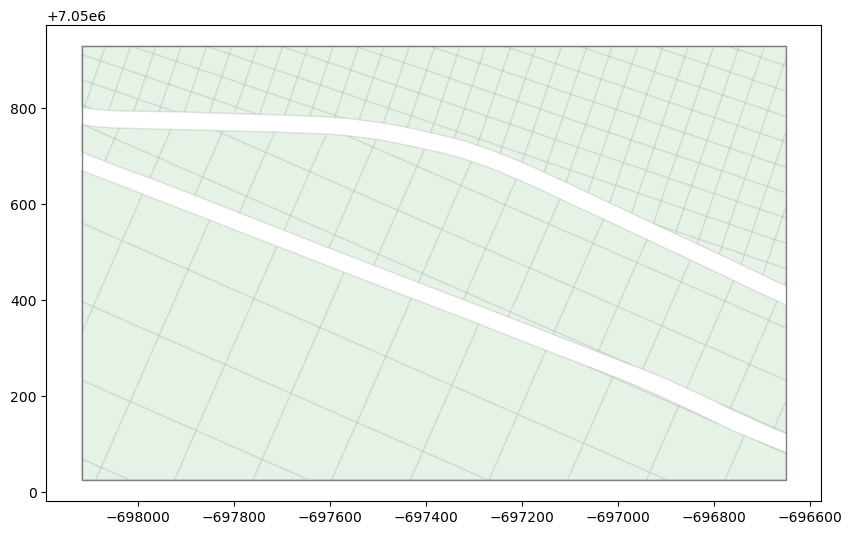

In [7]:
dcc = gpd.read_file('geojson_polygons/whitworth.geojson').to_crs(3857)
print(dcc)

rail = gpd.read_file('geojson_polygons/whitworth_rail.geojson').to_crs(3857)
dcc_squares = tile_squares(dcc, 100, 75)

rail = rail[rail['geometry'].geom_type == "LineString"]

rail_buffer = gpd.GeoDataFrame(pd.DataFrame(rail.buffer(15), columns=['geometry']), geometry='geometry')

join_test = dcc.overlay(rail_buffer, how='symmetric_difference')
rail_join = dcc.overlay(join_test, how='intersection')
join_grid = rail_join.overlay(test_squares, how='intersection')

rail_join_geoms = gpd.GeoDataFrame(pd.DataFrame(list(rail_join.loc[0]['geometry'].geoms), columns=['geometry']), geometry='geometry')

def get_multipoly_tiles(multipoly):
    poly_list = []
    multipoly_polys = list(multipoly.geoms)
    for poly in multipoly_polys:
        bb = poly.bounds
        poly_list.append(Polygon([(bb[0],bb[1]),(bb[0], bb[-1]),(bb[-2], bb[-1]),(bb[-2], bb[1])]))
    return gpd.GeoDataFrame(pd.DataFrame(zip(poly_list,multipoly_polys), columns=['bounding_box', 'geometry']), geometry='geometry')

def get_bounds_angle(shape):
    minx, miny, maxx, maxy = get_shape_bounds(shape)
    ox, oy = shape.centroid.x, shape.centroid.y
    w = maxx - minx
    h = maxy - miny

    bb_poly = Polygon([(minx,miny),(minx, maxy),(maxx, maxy),(minx, maxy)])

    points_list = [shapely.Point(x) for x in bb_poly.boundary.coords]
    points_list = points_list[:-1]

    point_a = points_list[0]
    point_b = points_list[2]

    dist = point_a.distance(point_b)

    theta = np.arcsin(h/dist)
    return theta * 180/np.pi
        
tiles1 = tile_squares(gpd.GeoDataFrame(pd.DataFrame([rail_join_geoms.iloc[0]['geometry']], columns=['geometry']), geometry='geometry'), 150, 90 - get_bounds_angle(rail_join_geoms.iloc[0]['geometry']))
tiles2 = tile_squares(gpd.GeoDataFrame(pd.DataFrame([rail_join_geoms.iloc[1]['geometry']], columns=['geometry']), geometry='geometry'), 100, 90 - get_bounds_angle(rail_join_geoms.iloc[1]['geometry']))
tiles3 = tile_squares(gpd.GeoDataFrame(pd.DataFrame([rail_join_geoms.iloc[2]['geometry']], columns=['geometry']), geometry='geometry'), 50, 90 - get_bounds_angle(rail_join_geoms.iloc[2]['geometry']))

test_bounds = get_bounds_points(dcc.iloc[0]['geometry'])

print(get_bounds_angle(rail_join_geoms.iloc[2]['geometry']))

fig, ax = plt.subplots(1,1,figsize=(10,10))
dcc.plot(ax=ax,facecolor='none', edgecolor='grey')
rail_join.plot(ax=ax, facecolor='none', edgecolor='grey', alpha=0.1)
tiles1.plot(ax=ax, facecolor='green', edgecolor='grey', alpha=0.1)
tiles2.plot(ax=ax, facecolor='green', edgecolor='grey', alpha=0.1)
tiles3.plot(ax=ax, facecolor='green', edgecolor='grey', alpha=0.1)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


## Trying out some road buffers in Whitworth

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 36 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

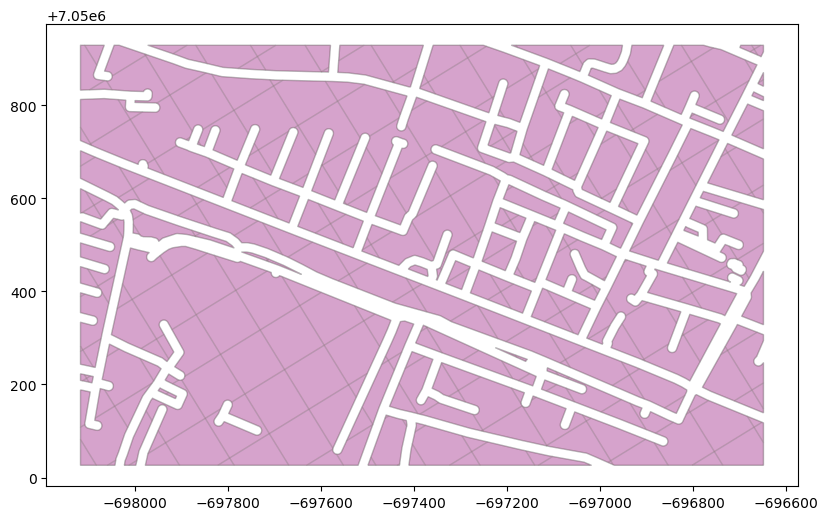

In [8]:
whit = gpd.read_file('geojson_polygons/whitworth.geojson').to_crs(3857)

road = gpd.read_file('geojson_polygons/whitworth_roads.geojson').to_crs(3857)
whit_squares = tile_squares(dcc, 100, get_bounds_angle(whit))

def tile_gdf(gdf, size, angle):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry')
    gdf_list = [gdf.iloc[[x]] for x in range(gdf.shape[0])]
    for x in gdf_list:
        gdf_out = pd.concat([gdf_out,tile_squares(x, size, get_bounds_angle(gdf))], ignore_index=True)
    return gdf_out

def multi_to_poly(multipoly):
    polygons = [poly for poly in multipoly.geoms]
    return gpd.GeoDataFrame(pd.DataFrame(polygons, columns=['geometry']), geometry='geometry')

def gdf_multi_to_poly(gdf):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry')
    for i in range(gdf.shape[0]):
        if isinstance(gdf['geometry'][i], shapely.geometry.multipolygon.MultiPolygon):
            gdf_out = pd.concat([gdf_out, multi_to_poly(gdf['geometry'][i])],ignore_index=True)
        else:
            gdf_out = pd.concat([gdf_out, gdf.iloc[[i]]],ignore_index=True)
    return gdf_out

road = road[road['geometry'].geom_type == "LineString"]

road_poly = gpd.GeoDataFrame(pd.DataFrame(road.buffer(1), columns=['geometry']), geometry='geometry')
road_buffer = gpd.GeoDataFrame(pd.DataFrame(road.buffer(10), columns=['geometry']), geometry='geometry')


road_buffer = whit.overlay(road_buffer, how='symmetric_difference')
road_buffer = whit.overlay(road_buffer, how='intersection')


road_buffer = gdf_multi_to_poly(road_buffer)
road_poly = whit.overlay(road_poly, how='intersection')
road_buffer_test = tile_gdf(road_buffer, 100, 45)

#road_buffer.set_crs(3857).to_file("geojson_polygons/whitworth_road_buffers.geojson", driver="GeoJSON")

fig, ax = plt.subplots(1,1,figsize=(12,6))

#whit.plot(ax=ax, facecolor='none', edgecolor='grey')
#whit_squares.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.2)
road_buffer.plot(ax=ax, facecolor='blue', edgecolor='black', alpha=0.2)
road_buffer_test.plot(ax=ax, facecolor='red', edgecolor='grey', alpha=0.2)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


## Uniform generation between road regions

Generated points: 10000


<Axes: >

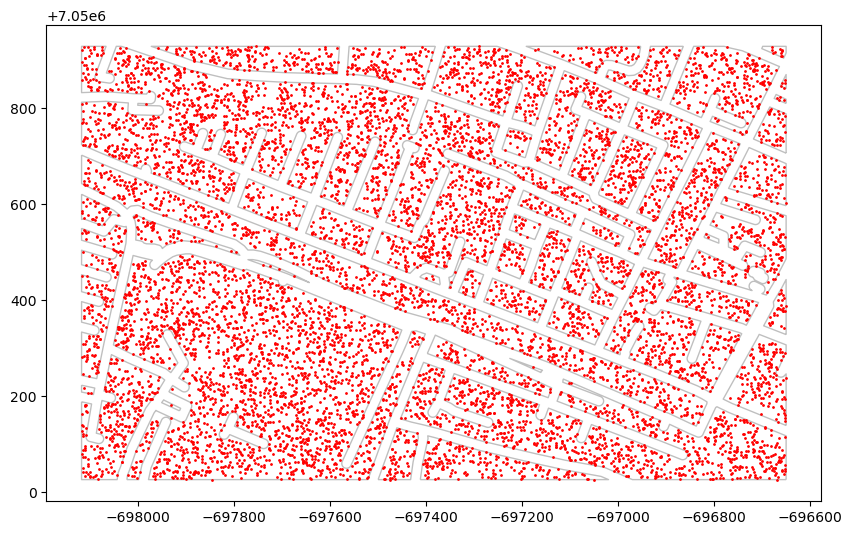

In [11]:
## Uniform generation pulled from RADIAN

def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def points_uniform(gdf_poly, num_points, min_distance=0):
    min_x, min_y, max_x, max_y = gdf_poly.total_bounds

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < 2*num_points: # quick and dirty implementation, x2 is too many points
        new_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        points.append(new_point)
        
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    #gdf = gdf.sjoin(gdf_poly, predicate='within')
    gdf = gdf.overlay(gdf_poly, how='intersection')
    #gdf = gdf.drop(['index_right'], axis=1)
    return gdf.sample(num_points).reset_index(drop=True)#.iloc[0:num_points].reset_index(drop=True)

whitworth_poly = gpd.read_file("geojson_polygons/whitworth_road_buffers.geojson")

whitworth_points = points_uniform(whitworth_poly, 10000)

print("Generated points:", len(whitworth_points))

fig, ax = plt.subplots(1,1,figsize=(10,8))

whitworth_poly.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.25)
whitworth_points.plot(ax=ax, color='red', markersize=1)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


## Road buffers for generation near edges of polygon regions

<Axes: >

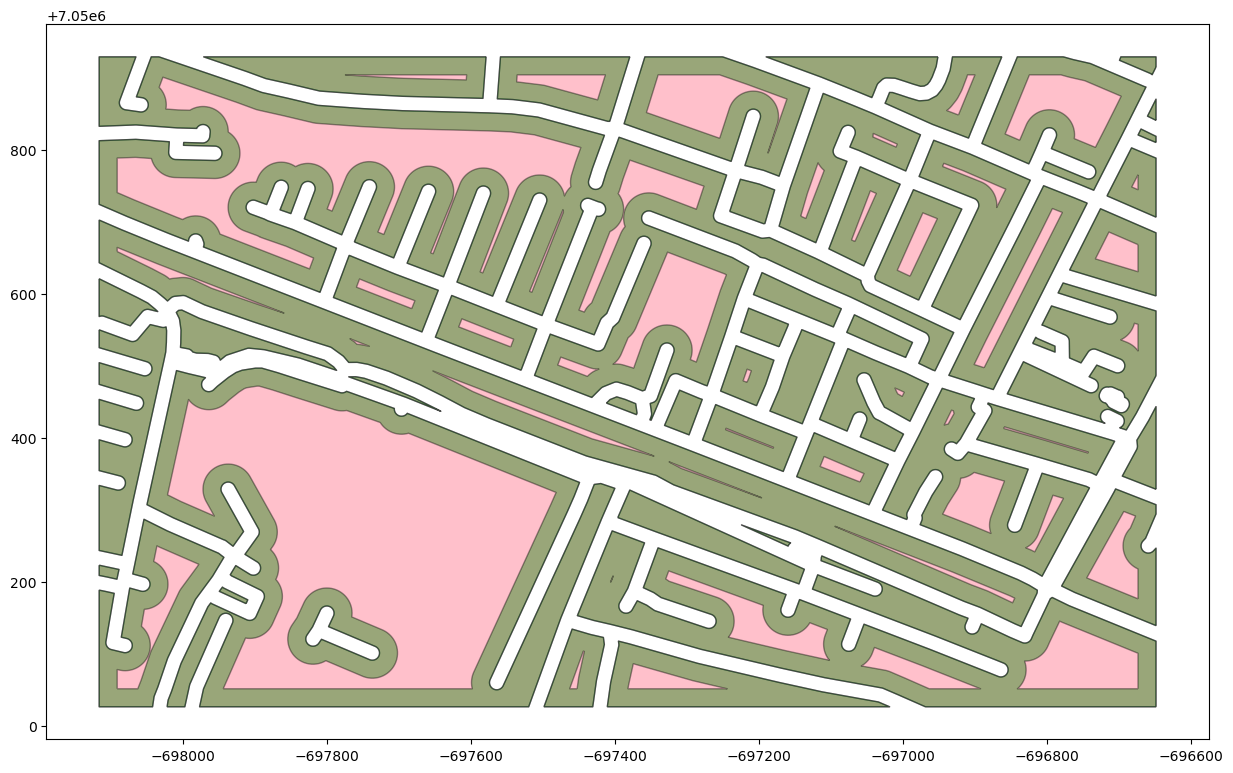

In [12]:
whitworth_poly = gpd.read_file("geojson_polygons/whitworth_road_buffers.geojson")

def point_on_line(line):
    p1 = line.coords[0]
    p2 = line.coords[-1]
    u = random.uniform(0,1)
    
    x1 = [(1-u) * x for x in p1]
    x2 = [u*x for x in p2]
    return Point(np.add(x1,x2))

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

def points_on_vertices(shape):
    vertices = segments(shape.boundary)
    return gpd.GeoDataFrame(pd.DataFrame([point_on_line(x) for x in vertices], columns=['geometry']),geometry='geometry')

def get_bounds_points(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.boundary.coords], columns=['geometry']),geometry='geometry')

def get_bounds_points_linestring(shape):
    return gpd.GeoDataFrame(pd.DataFrame([shapely.Point(x) for x in shape.coords], columns=['geometry']),geometry='geometry')

test_poly = whitworth_poly#.iloc[[2]]
test_buffer = test_poly.buffer(-25)
test_join = test_poly.symmetric_difference(test_buffer)
#test_join_buffer = test_join.buffer(-2)


fig, ax = plt.subplots(1,1,figsize=(15,10))

test_poly.plot(ax=ax, facecolor='pink', edgecolor='grey')
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

test_join.plot(ax=ax, facecolor='green', edgecolor='black', alpha=0.4)


## Generating points through the generation of polygons

In [13]:
def square_origin(origin, side):
    #z = np.sqrt(area)/2
    z = side/2
    ox, oy = origin.x, origin.y
    return Polygon([(ox-z,oy-z),(ox-z,oy+z), (ox+z, oy+z), (ox+z, oy-z)])

def get_shape_bounds(shape):
    if isinstance(shape, gpd.geodataframe.GeoDataFrame) or isinstance(shape, gpd.geoseries.GeoSeries):
        return shape.total_bounds
    else:
        return shape.bounds

def get_bounds_angle(shape):
    minx, miny, maxx, maxy = get_shape_bounds(shape)
    ox, oy = shape.centroid.x, shape.centroid.y
    w = maxx - minx
    h = maxy - miny

    bb_poly = Polygon([(minx,miny),(minx, maxy),(maxx, maxy),(minx, maxy)])

    points_list = [shapely.Point(x) for x in bb_poly.boundary.coords]
    points_list = points_list[:-1]

    point_a = points_list[0]
    point_b = points_list[2]

    dist = point_a.distance(point_b)

    theta = np.arcsin(h/dist)
    return theta * 180/np.pi

def tile_squares(shape, side, angle):
    ox, oy = shape.centroid.x, shape.centroid.y
    minx, miny, maxx, maxy = get_shape_bounds(shape.rotate(angle, origin=Point([ox,oy])))
    w = maxx - minx
    h = maxy - miny

    ratio = w/h

    # if ratio > 1: wider than tall
    # if ratio <1 : taller than wide
    x_ratio = y_ratio = (ratio + 2)

    if ratio > 1:
        x_ratio /= 2
    else:
        y_ratio /= 2

    grid_x = int(x_ratio * np.ceil(w/side)) + 1
    grid_y = int(y_ratio * np.ceil(h/side)) + 1

    w_offset = abs(w - (side * grid_x))
    h_offset = abs(h - (side * grid_y))

    x = ox - (w/2 + w_offset/2) + side/2
    y = oy - (h/2 + h_offset/2) + side/2

    square_list = []
    for i in range(grid_x):
        for j in range(grid_y):
            origin = Point([x + (i*side), y + (j*side)])
            square_list.append(square_origin(origin, side))

    squares = gpd.GeoDataFrame(pd.DataFrame(square_list, columns=['geometry']), geometry='geometry')
    squares_rotate = gpd.GeoDataFrame(geometry=squares.rotate(angle, origin=Point([ox,oy])), crs=shape.crs) 
    return shape.overlay(squares_rotate, how='intersection',keep_geom_type=False)

def tile_gdf(gdf, size, angle):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry')
    gdf_list = [gdf.iloc[[x]] for x in range(gdf.shape[0])]
    for x in gdf_list:
        gdf_out = pd.concat([gdf_out,tile_squares(x, size, angle)], ignore_index=True)
    return gdf_out

buffers = gpd.GeoDataFrame(geometry=test_join)

test_squares = tile_gdf(buffers, 40, -20)

building_buffers = test_squares.buffer(-4)
building_buffers = building_buffers[building_buffers.is_empty == False].reset_index(drop=True)

def gdf_jitter(gdf, change=5):
    # take in a gdf of points and return the same gdf with the location altered by given percentage
    for i, geom in enumerate(gdf):
        gx, gy = geom.x, geom.y
        gdf[i] = Point([gx + random.uniform(-change, change), gy + random.uniform(-change, change)])
    return gdf

roads = gpd.read_file('geojson_polygons/whitworth_roads.geojson').to_crs(3857)

building_points_jitter = gdf_jitter(building_buffers.centroid, 5)

816
652


<Axes: >

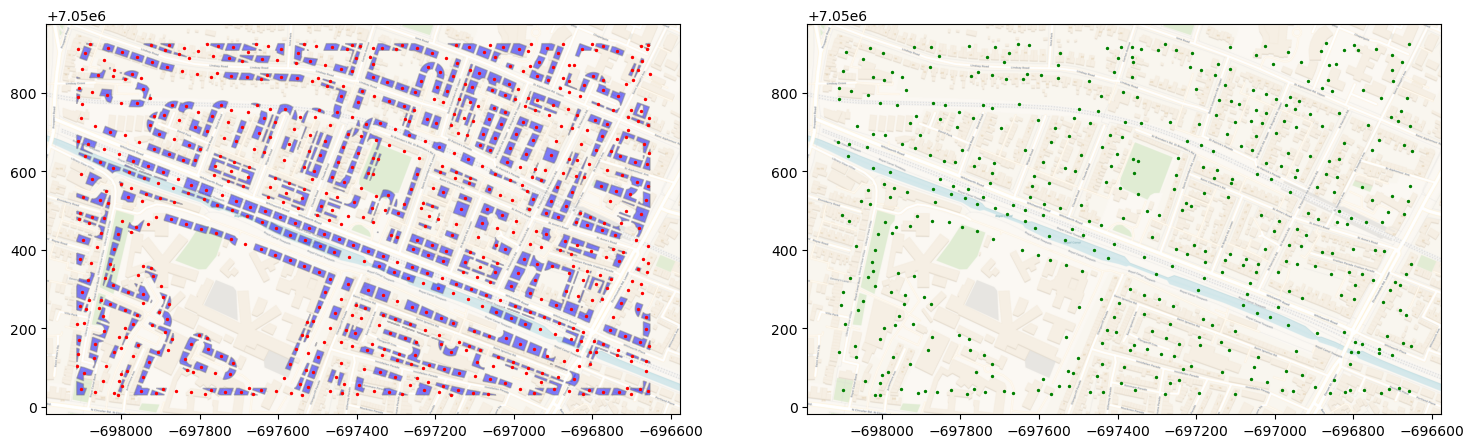

In [14]:
fig, axs = plt.subplots(1,2,figsize=(18,15))

for ax in axs.flatten():
    # set basemap for each plot
    buffers.plot(ax=ax, facecolor='none', edgecolor='none', alpha=0.8)
    cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)


print(len(building_buffers))

# plotting polygons, buffer shapes, and centroids
building_buffers.sample(600).plot(ax=axs[0], facecolor='blue', edgecolor='grey', alpha=0.5)
building_buffers.centroid.plot(ax=axs[0], color='red', markersize=2)

print(int(len(building_points_jitter) * 0.8))

# plotting just the points
building_points_jitter.sample(int(len(building_points_jitter) * 0.6)).plot(ax=axs[1], color='green',markersize=2)
#roads.plot(ax=axs[1], alpha=0.4)

#building_buffers.to_file("geojson_polygons/whitworth_fake_buildings.geojson", driver="GeoJSON")